# Project: Mental Attention States Classification Using EEG Data

## I. Loading Dataset

In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def loading_data(file_path):
    """
    Đọc và trả về dữ liệu từ file .mat.
    """
    try:
        data = loadmat(file_path)
        result = data['o']['data'][0, 0]  
        return result
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None

In [3]:
useful_file_index = [3,4,5,6,7,10,11,12,13,14,17,18,19,20,21,24,25,26,27, 28, 31,32,33,34]
eeg_data_dict = {}

for i in useful_file_index:
    eeg_data_dict[f"eeg_data_{i}"] = []


In [4]:
for i in useful_file_index:
    file_path = f"EEG Data/eeg_record{i}.mat"
    try:
        data = loading_data(file_path)
        features = data[:, 4:18]
        eeg_data_dict[f"eeg_data_{i}"].append(features)
    except Exception as e:
        print(f'Error loading file {file_path}: {e}')


## II. Data Preprocessing

### 1. Bandpass Filter

In [5]:
from scipy.signal import butter, lfilter


In [6]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Áp dụng bộ lọc thông dải (bandpass filter) cho dữ liệu tín hiệu.

    Parameters:
        - data: ndarray
            Mảng tín hiệu EEG (mỗi hàng là một channel).
        - lowcut: float
            Tần số cắt thấp (Hz).
        - highcut: float
            Tần số cắt cao (Hz).
        - fs: float
            Tần số lấy mẫu (sampling frequency) của tín hiệu (Hz).
        - order: int
            Bậc của bộ lọc Butterworth.

    Returns:
        - filtered_data: ndarray
            Tín hiệu sau khi được lọc.
    """
    nyquist = 0.5 * fs  
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')  
    filtered_data = lfilter(b, a, data, axis=0)  
    return filtered_data


In [ ]:
for key, data in eeg_data_dict.items():
    try:
        filtered_data = bandpass_filter(data, lowcut=1, highcut=30, fs=128)  
        eeg_data_dict[key] = filtered_data
    except Exception as e:
        print(f"Error filtering data for {key}: {e}")


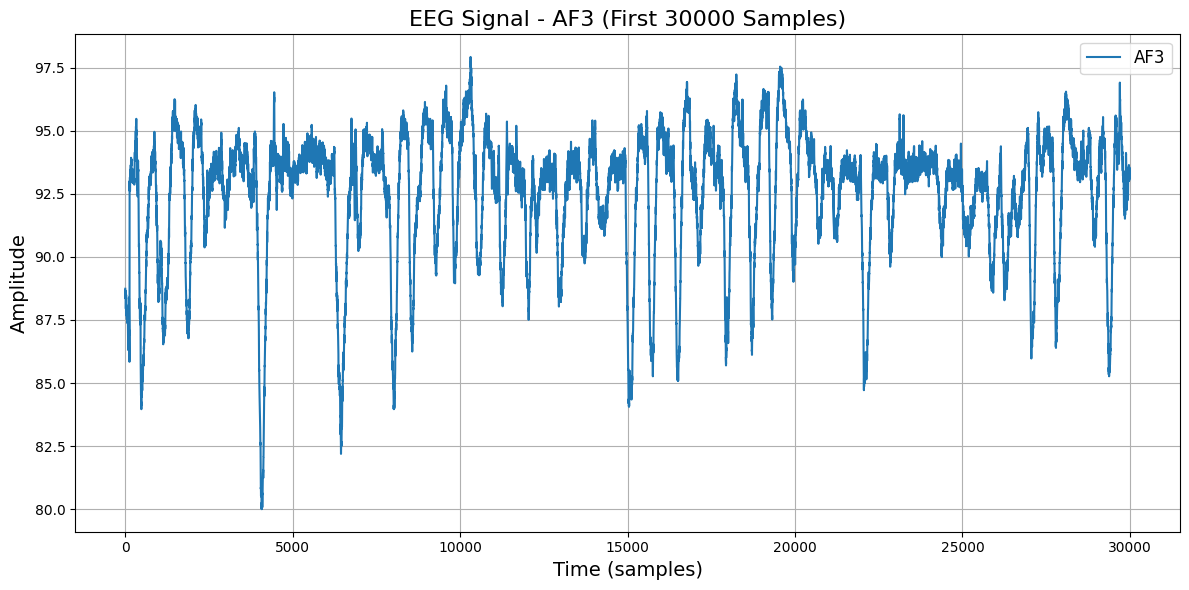

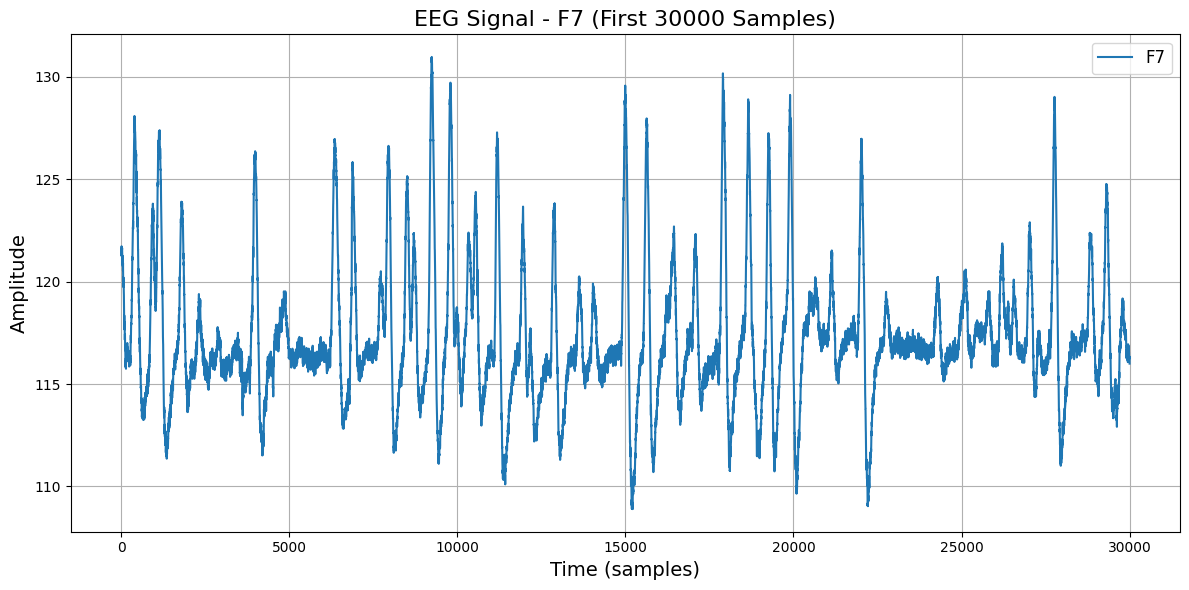

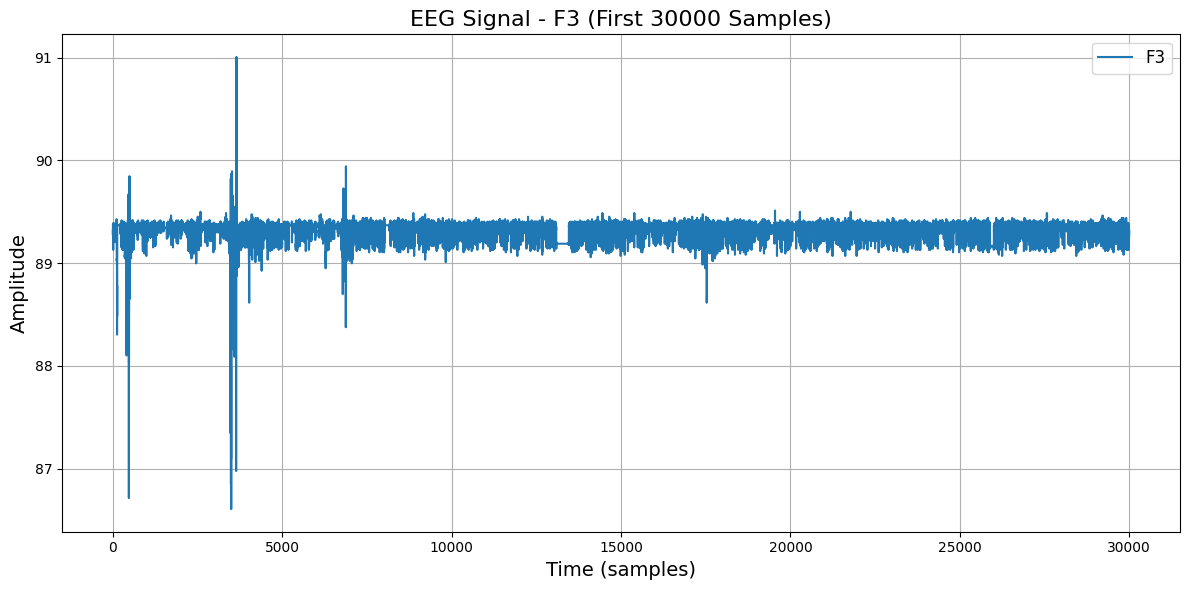

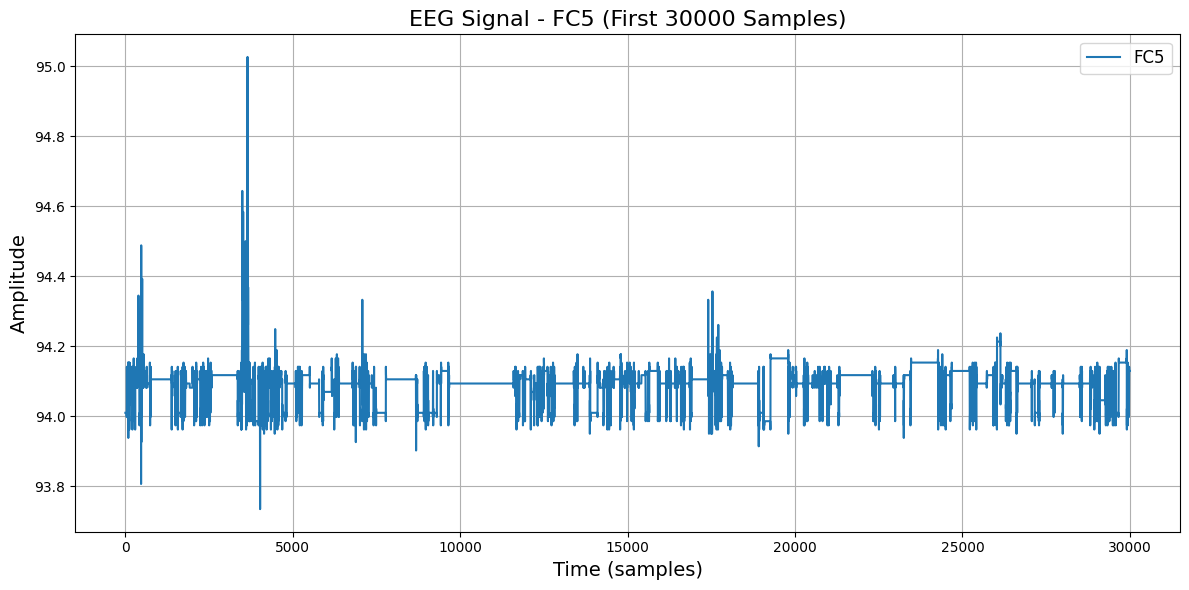

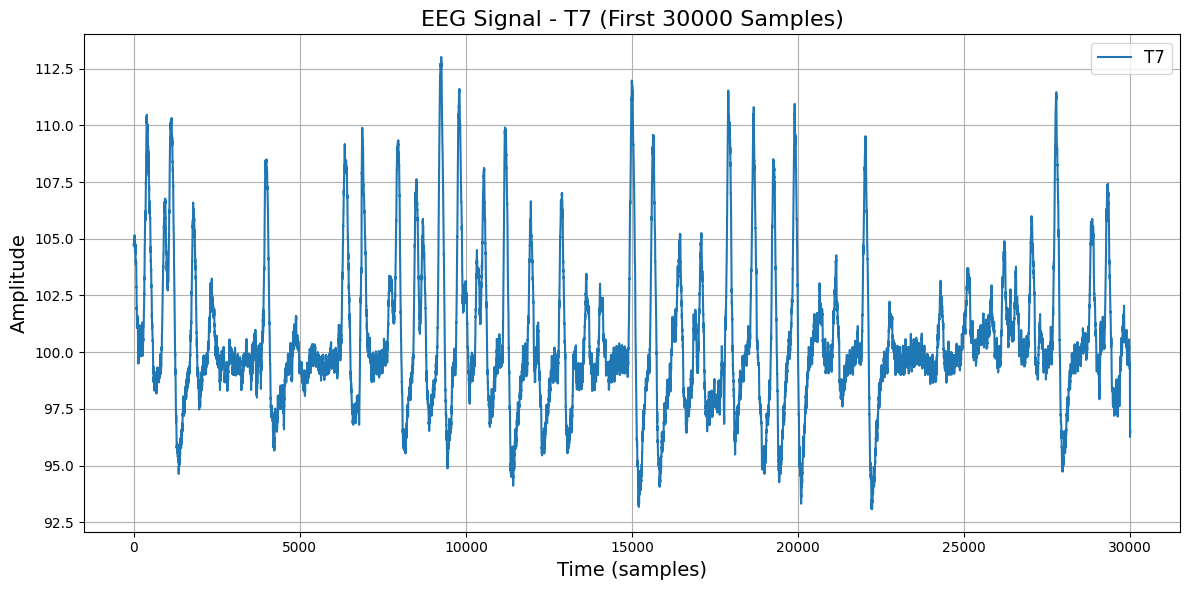

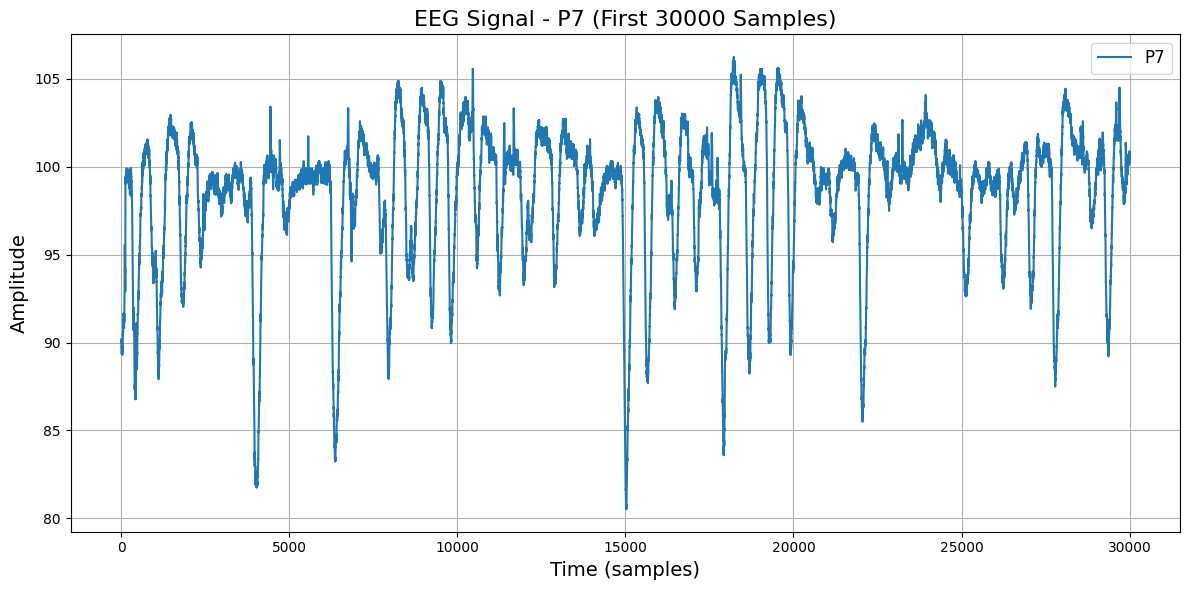

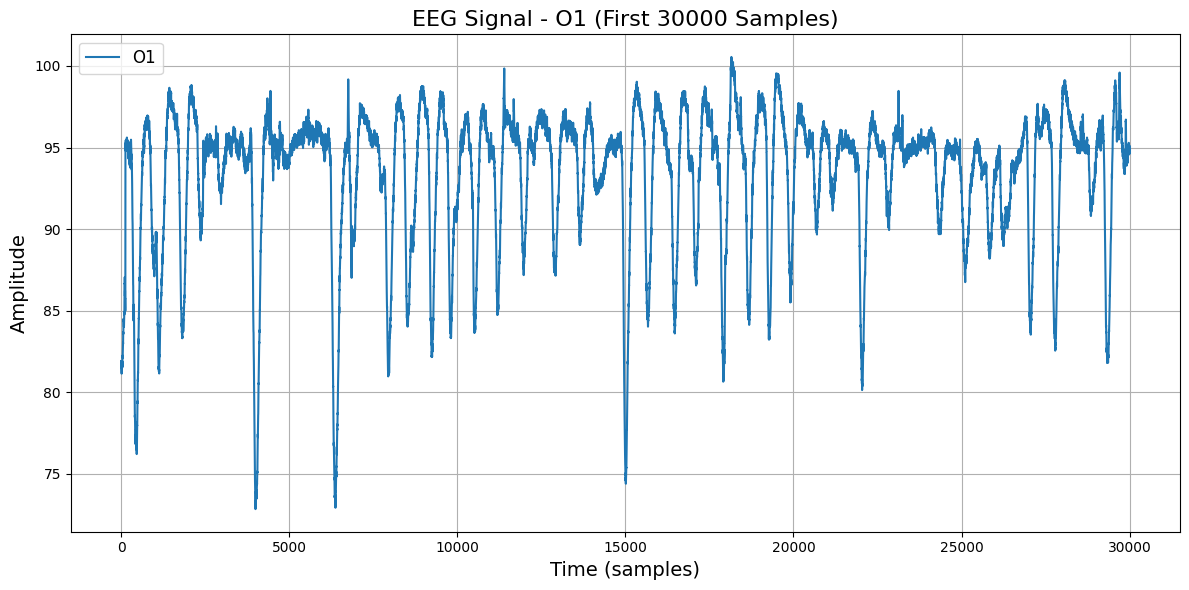

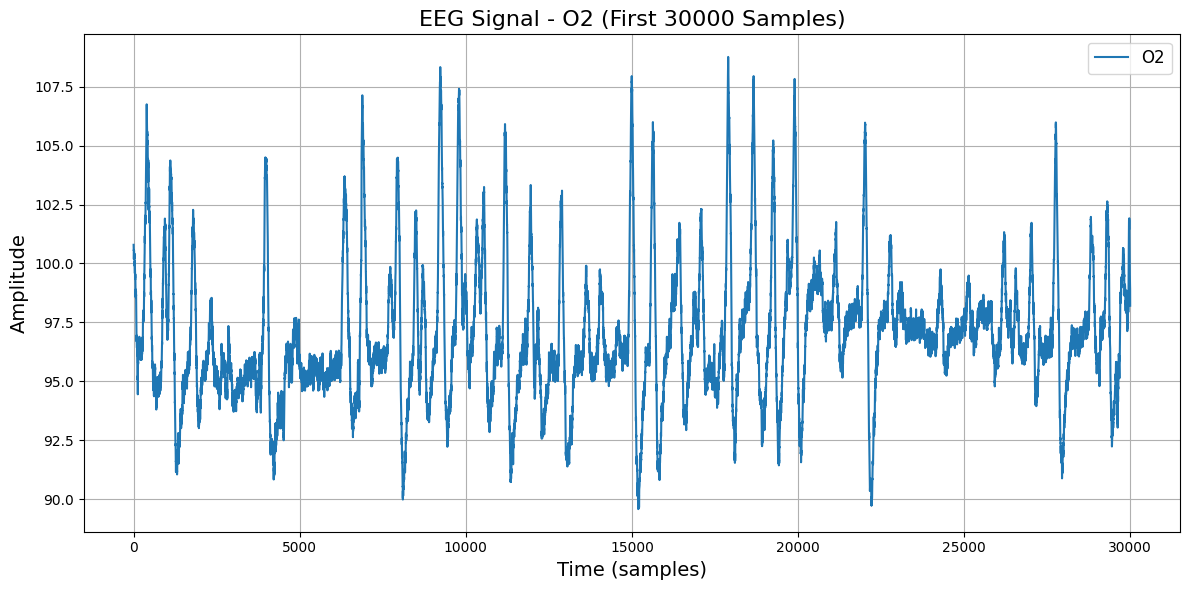

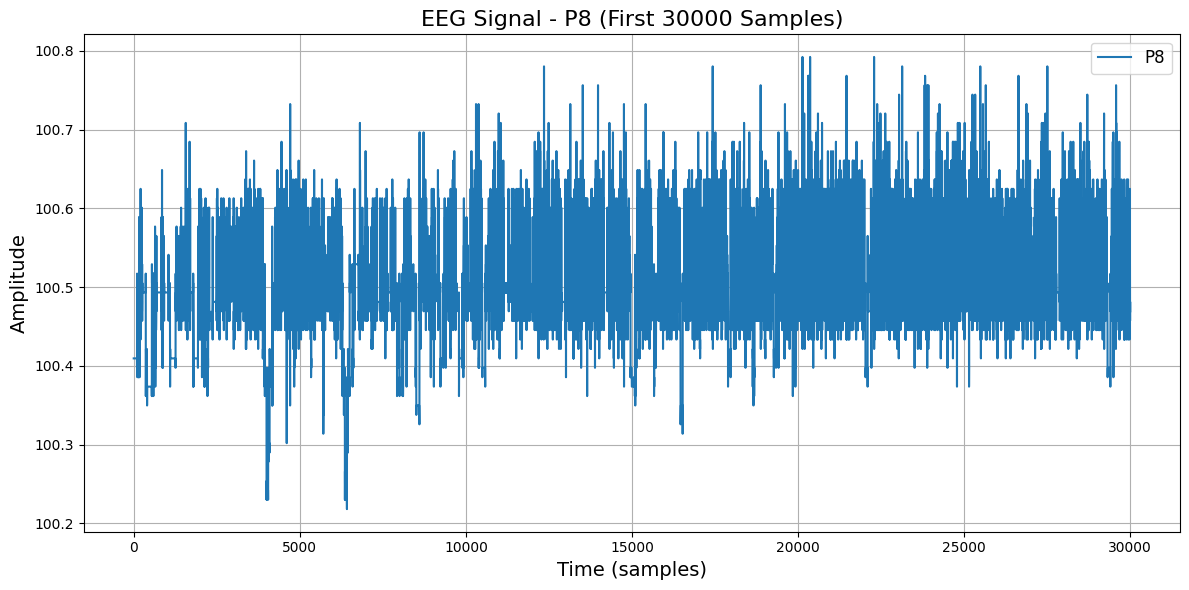

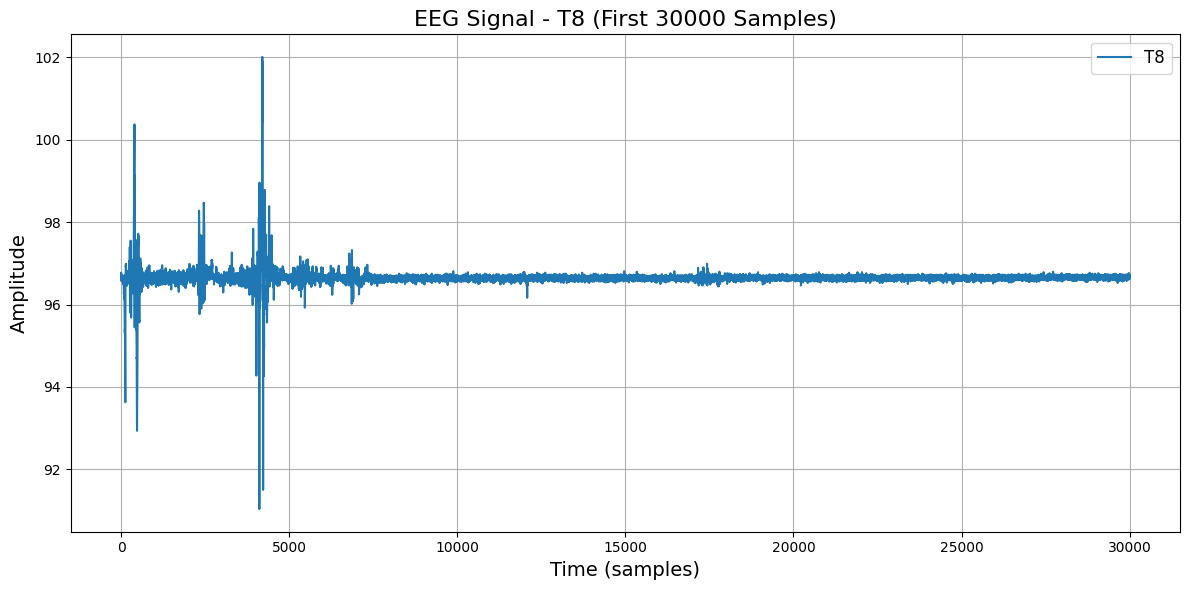

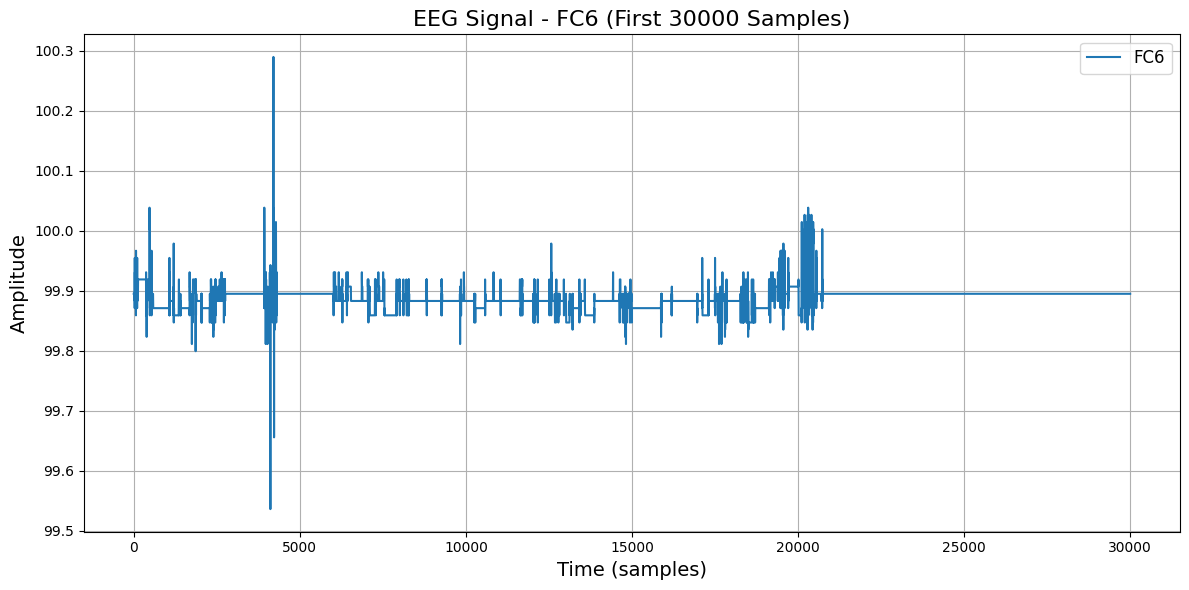

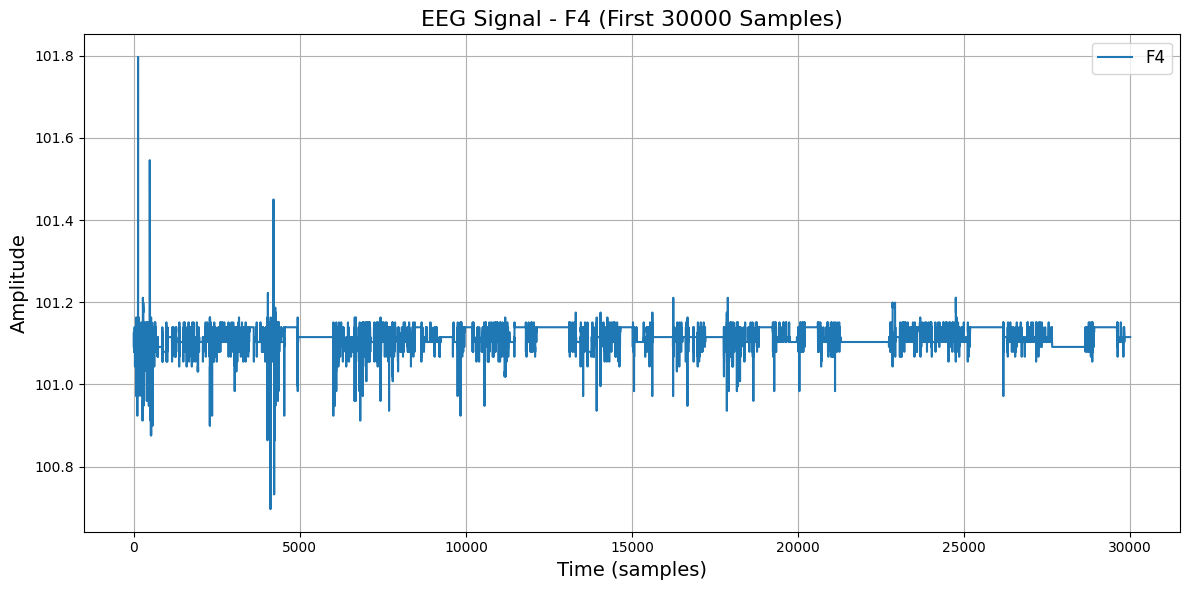

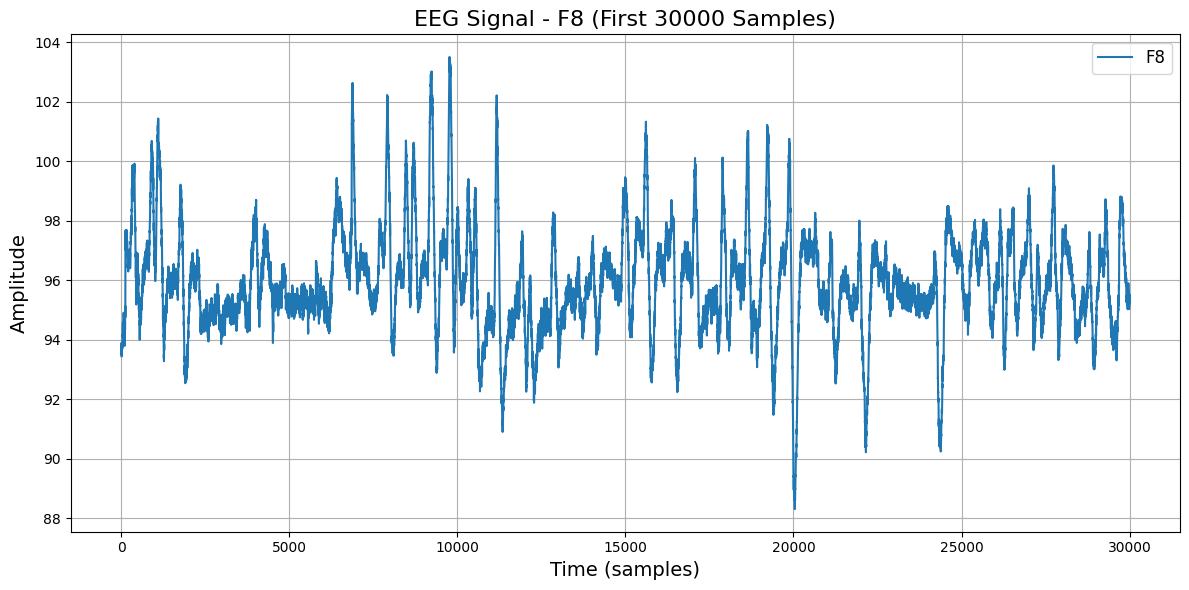

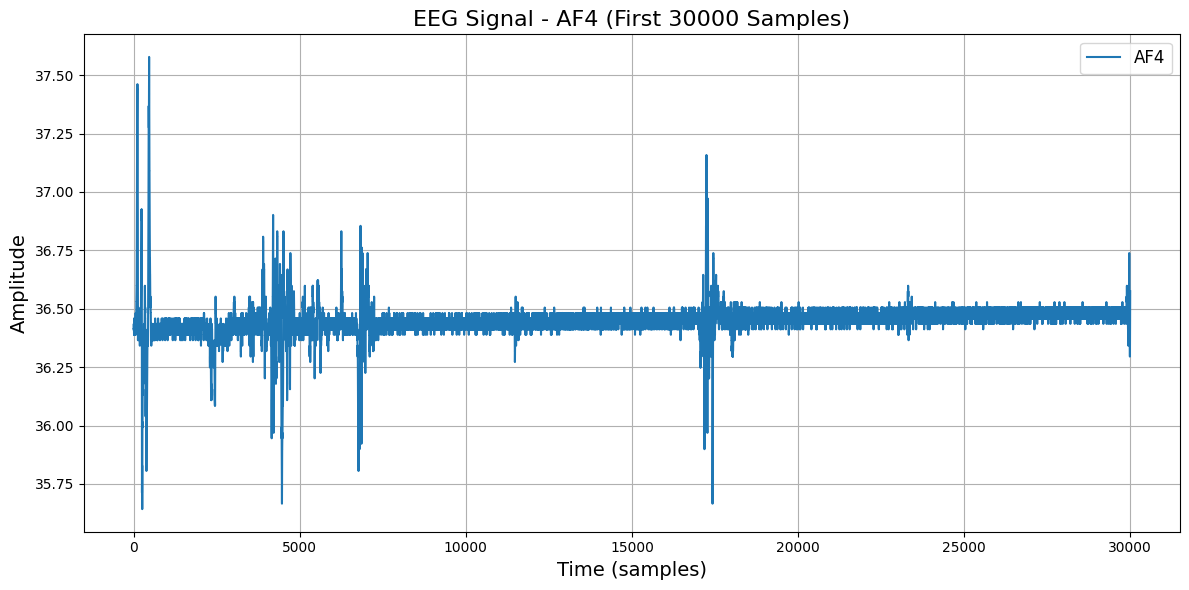

In [8]:
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

key = "eeg_data_3"
if key in eeg_data_dict:
    eeg_data = eeg_data_dict[key]
    eeg_data = eeg_data[0]  

    num_samples_to_plot = 30000
    limited_data = eeg_data[:num_samples_to_plot]

    time = np.arange(limited_data.shape[0])

    for i in range(limited_data.shape[1]):  #
        plt.figure(figsize=(12, 6))
        plt.plot(time, limited_data[:, i], label=f"{channels[i]}")
        plt.title(f"EEG Signal - {channels[i]} (First {num_samples_to_plot} Samples)", fontsize=16)
        plt.xlabel("Time (samples)", fontsize=14)
        plt.ylabel("Amplitude", fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print(f"{key} does not exist in eeg_data_dict.")


### 2. Normalization

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [10]:
def normalization_standard(x_data):
    scaler = StandardScaler()
    x_data_reshaped = x_data.reshape(-1, x_data.shape[2])  
    x_data_normalized = scaler.fit_transform(x_data_reshaped)
    x_data_normalized = x_data_normalized.reshape(x_data.shape) 
    return x_data_normalized

In [11]:
normalized_eeg_data_dict = {}

for key in eeg_data_dict:
    eeg_data = eeg_data_dict[key]
    eeg_data = eeg_data[0]

    normalized_eeg_data_dict[key] = normalization_standard(eeg_data_dict[key])
    

### 3. Application ICA

In [12]:
from sklearn.decomposition import FastICA


In [13]:
def apply_ICA(x_data, n_components=6):
    ica = FastICA(n_components=n_components, random_state=42)
    x_data_reshaped = x_data.reshape(-1, x_data.shape[2])
    x_ica = ica.fit_transform(x_data_reshaped)
    x_ica = x_ica.reshape(x_data.shape[0], x_data.shape[1], n_components)
    
    return x_ica


In [14]:
ica_eeg_data_dict = {}

for key in eeg_data_dict:
    eeg_data = eeg_data_dict[key]
    eeg_data = eeg_data[0]
    ica_eeg_data_dict[key] = apply_ICA(normalized_eeg_data_dict[key], n_components=6)
    

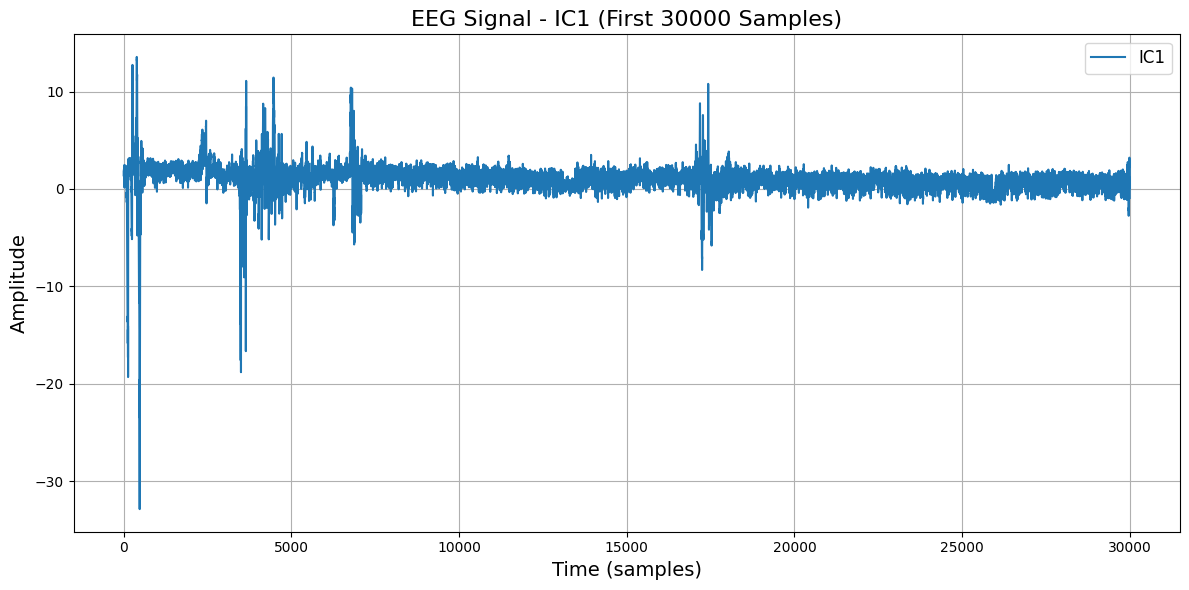

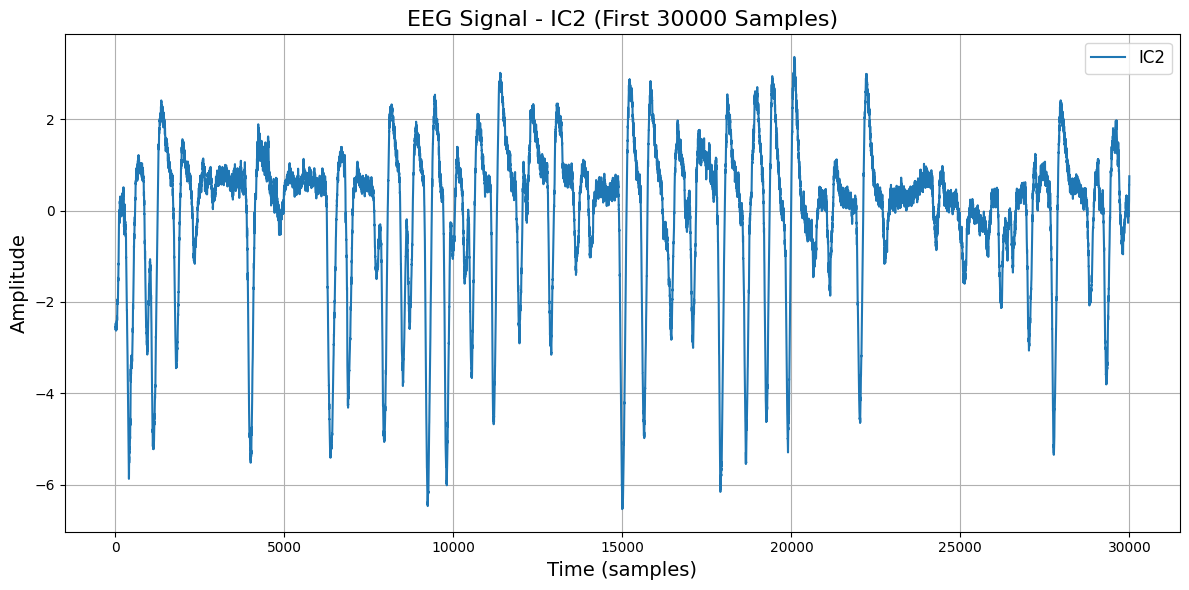

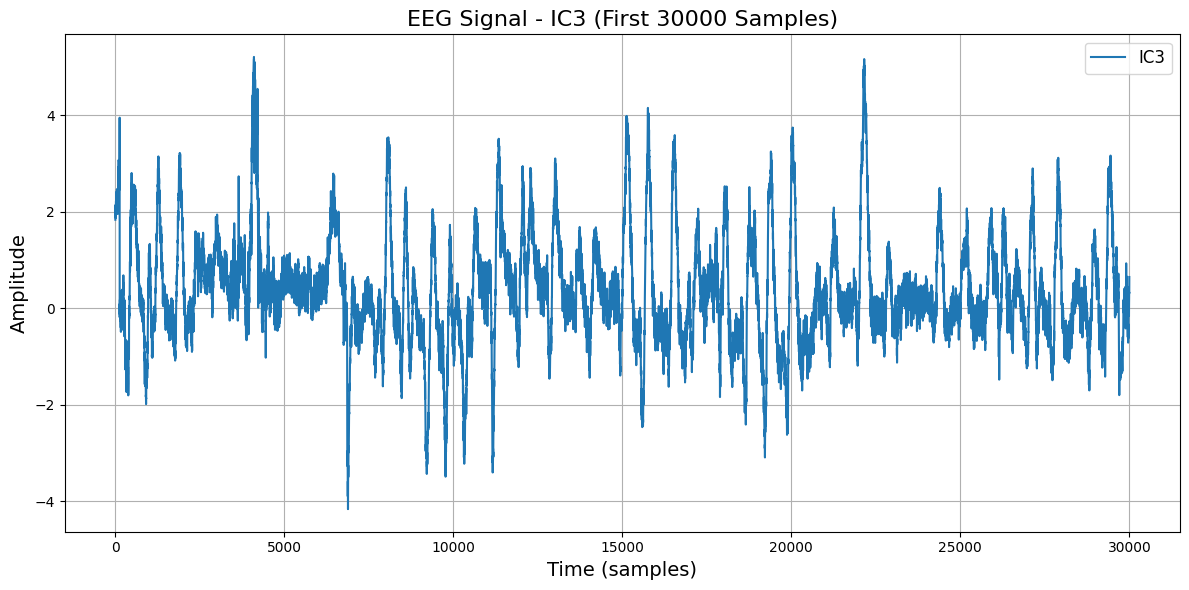

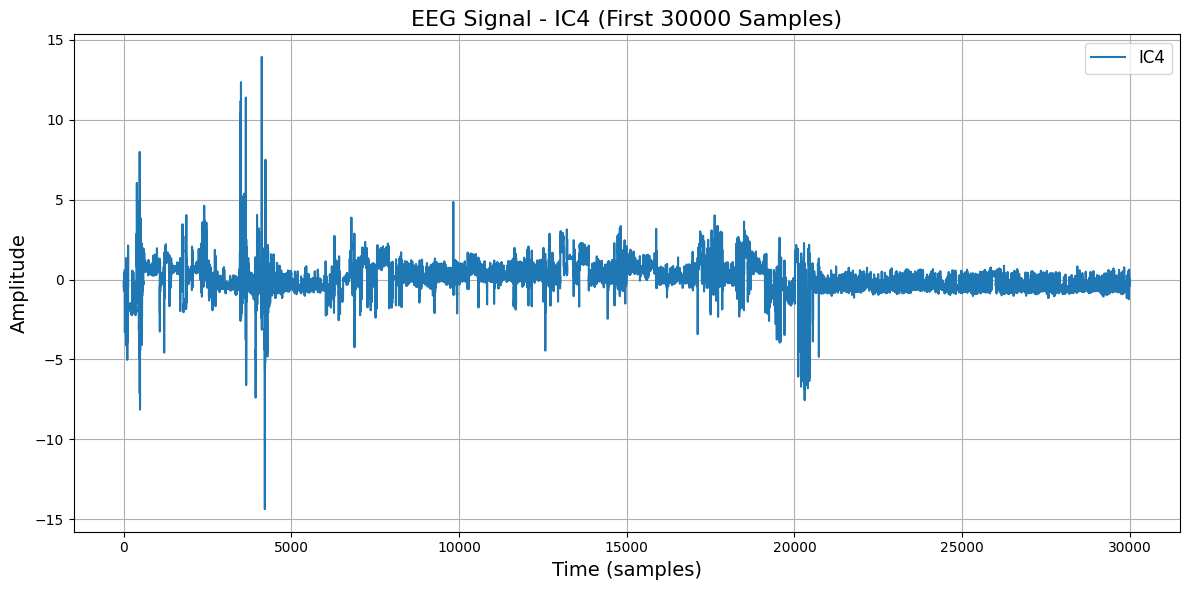

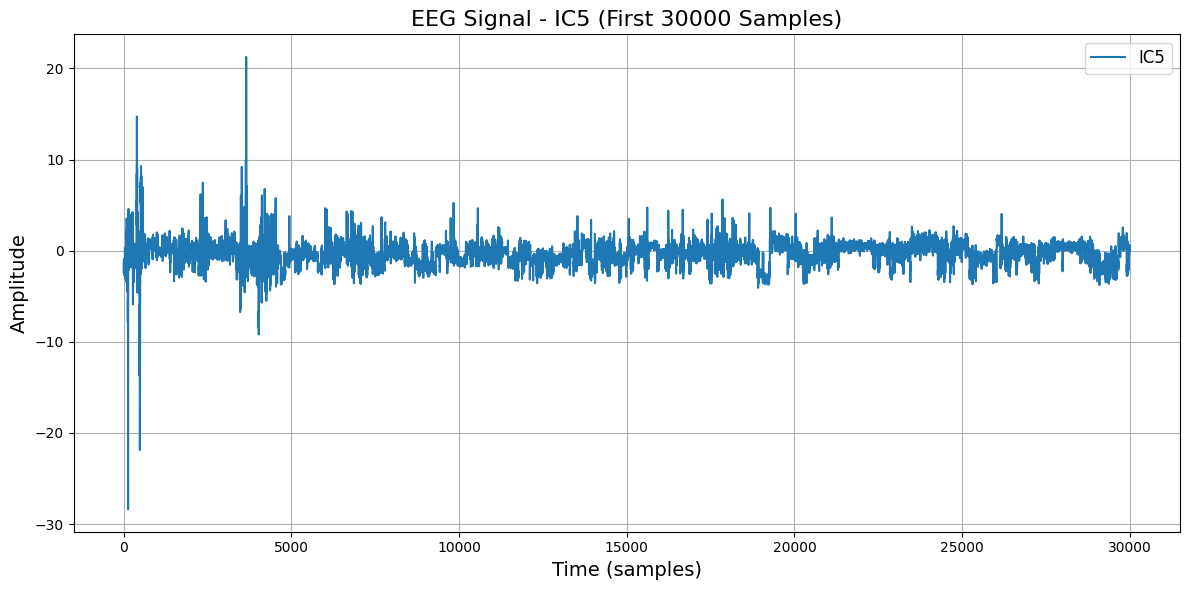

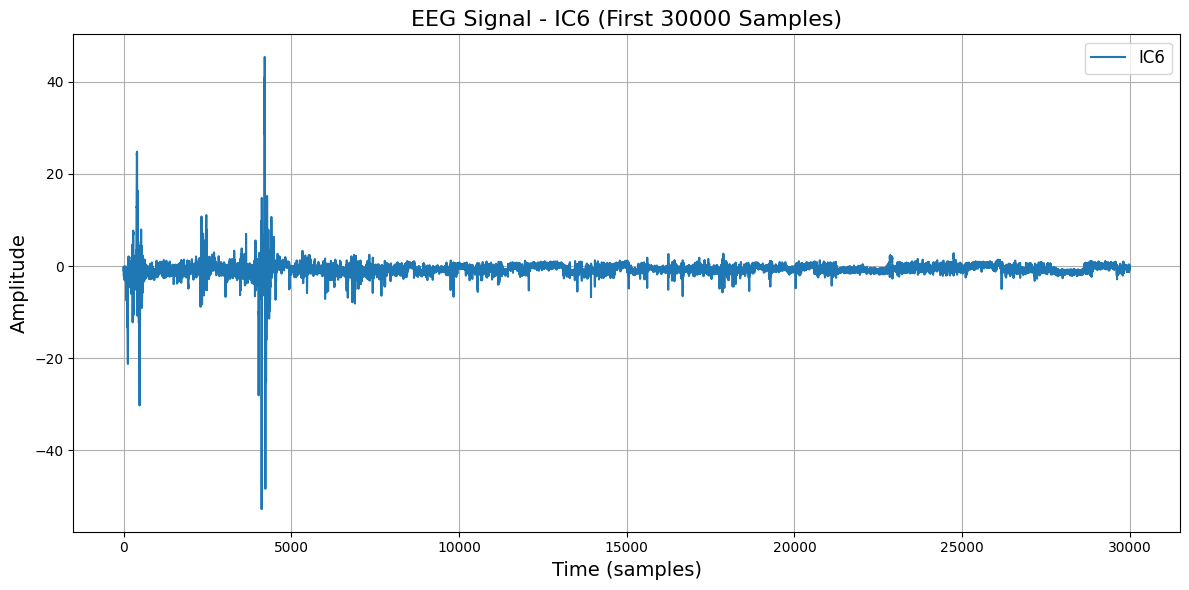

In [15]:
channels = ['IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6']

key = "eeg_data_3"
if key in ica_eeg_data_dict:
    eeg_data = ica_eeg_data_dict[key]
    eeg_data = eeg_data[0]  

    num_samples_to_plot = 30000
    limited_data = eeg_data[:num_samples_to_plot]

    time = np.arange(limited_data.shape[0])

    for i in range(limited_data.shape[1]):  
        plt.figure(figsize=(12, 6))
        plt.plot(time, limited_data[:, i], label=f"{channels[i]}")
        plt.title(f"EEG Signal - {channels[i]} (First {num_samples_to_plot} Samples)", fontsize=16)
        plt.xlabel("Time (samples)", fontsize=14)
        plt.ylabel("Amplitude", fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print(f"{key} does not exist in eeg_data_dict.")


### 4. Split data set

In [16]:
def split_eeg_data(eeg_data, sample_rate=128, milestone_focused=10, milestone_unfocused=20):
    """
    Hàm tách dữ liệu EEG thành ba phần: Focused, Unfocused, Drowsy.
    
    Parameters:
    - eeg_data: Dữ liệu EEG dưới dạng numpy array (mảng 2D với dạng (số mẫu, số kênh)).
    - sample_rate: Tần số lấy mẫu (Hz), mặc định là 128 Hz.
    - duration_focused: Thời gian cho phần "Focused" (phút), mặc định là 10 phút.
    - duration_unfocused: Thời gian cho phần "Unfocused" (phút), mặc định là 10 phút.
    
    Returns:
    - focused_data: 10 phút đầu tiên, 
    - unfocused_data: 10 phút tiếp theo, 
    - drowsy_data: Phần còn lại.
    """
    focus_samples = milestone_focused * 60 * sample_rate  
    unfocus_samples = milestone_unfocused * 60 * sample_rate 
    total_samples = eeg_data.shape[0]
    
    if total_samples < focus_samples:
        focus_data = eeg_data[:]

    elif total_samples < unfocus_samples:
        focus_data = eeg_data[:(focus_samples)]
        unfocus_data = eeg_data[focus_samples:]
        drowsy_data = np.array([])   

    else:
        focus_data = eeg_data[:focus_samples]
        unfocus_data = eeg_data[focus_samples:unfocus_samples]
        drowsy_data = eeg_data[unfocus_samples:]  
    
    return focus_data, unfocus_data, drowsy_data


In [17]:
for key in ica_eeg_data_dict:
    eeg_data = ica_eeg_data_dict[key][0] 
    
    focus, unfocus, drowsy = [], [], []
    focus, unfocus, drowsy = split_eeg_data(eeg_data)
    
    print(f"{key}:")
    print(f"Focused: {focus.shape[0]} samples")
    print(f"Unfocused: {unfocus.shape[0]} samples")
    print(f"Drowsy: {drowsy.shape[0]} samples")
    print()

    

eeg_data_3:
Focused: 76800 samples
Unfocused: 76800 samples
Drowsy: 203624 samples

eeg_data_4:
Focused: 76800 samples
Unfocused: 76800 samples
Drowsy: 226744 samples

eeg_data_5:
Focused: 76800 samples
Unfocused: 76800 samples
Drowsy: 197604 samples

eeg_data_6:
Focused: 76800 samples
Unfocused: 76800 samples
Drowsy: 135152 samples

eeg_data_7:
Focused: 76800 samples
Unfocused: 76800 samples
Drowsy: 245216 samples

eeg_data_10:
Focused: 76800 samples
Unfocused: 76800 samples
Drowsy: 227740 samples

eeg_data_11:
Focused: 76800 samples
Unfocused: 76800 samples
Drowsy: 238024 samples

eeg_data_12:
Focused: 76800 samples
Unfocused: 76800 samples
Drowsy: 203128 samples

eeg_data_13:
Focused: 76800 samples
Unfocused: 76800 samples
Drowsy: 219704 samples

eeg_data_14:
Focused: 76800 samples
Unfocused: 76800 samples
Drowsy: 191564 samples

eeg_data_17:
Focused: 76800 samples
Unfocused: 76800 samples
Drowsy: 290372 samples

eeg_data_18:
Focused: 76800 samples
Unfocused: 76800 samples
Drowsy: 2

In [18]:
flag = []

for i in range(0, 2655):
    flag.append(i * 128)

In [19]:
def split_eeg_data_by_time(eeg_data, flag, label=0, sample_rate=128):
    """
    Chia dữ liệu EEG thành các phần khoảng 2s (256 time points) theo mốc từ `flag`.'
    
    Áp dụng 50% overlap cho training set:
    Nếu là label focus hoặc label unfocus: Thì hai windows liên tiếp nhau sẻ trùng nhau 1s.
    Để xử lý vấn đề mất cân bằng dữ liệu của dataset.
    Nếu là label drowsy: Thì hai windows liên tiếp nhau sẻ không bị trùng lặp dữ liệu.
    
    Parameters:
    - eeg_data: Dữ liệu EEG dưới dạng numpy array (mảng 2D với dạng (số mẫu, số kênh)).
    - flag: Mảng chứa các chỉ số thời gian (sample indices) theo mốc.
    - sample_rate: Tần số lấy mẫu (Hz), mặc định là 128 Hz.
    
    Returns:
    - segments: Danh sách các phần được chia từ dữ liệu EEG.
    """
    segments = []
    total_samples = eeg_data.shape[0]

    if label == 0:
        for i in range(0, len(flag) - 1, 2): 
            start_sample = flag[i]
            if i + 2 < len(flag):
                end_sample = flag[i + 2]
            else:
                break
            if start_sample < total_samples and end_sample <= total_samples:
                segments.append(eeg_data[start_sample:end_sample])
            else:
                break  
    else:
        for i in range(0, len(flag), 1): 
            start_sample = flag[i]
            if i + 2 < len(flag):
                end_sample = flag[i + 2]
            else:
                break
            if start_sample < total_samples and end_sample <= total_samples:
                segments.append(eeg_data[start_sample:end_sample])
            else:
                break        

    return segments


In [20]:
focus_train, unfocus_train, drowsy_train = [], [], []
idx_train = [3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28]

for count in idx_train:
    eeg_data = ica_eeg_data_dict[f'eeg_data_{count}'][0] 
    
    focus, unfocus, drowsy = [], [], []
    focus, unfocus, drowsy = split_eeg_data(eeg_data)

    temp_focused = split_eeg_data_by_time(focus, flag, label=1)
    temp_unfocused = split_eeg_data_by_time(unfocus, flag, label=1)
    temp_drowsy = split_eeg_data_by_time(drowsy, flag)

    for i in range(len(temp_focused)):
        focus_train.append(temp_focused[i])

    for i in range(len(temp_unfocused)):
        unfocus_train.append(temp_unfocused[i])

    for i in range(len(temp_drowsy)):
        drowsy_train.append(temp_drowsy[i])
    

In [21]:
focus_train = np.stack(focus_train, axis=0)
print("Shape of focused_train:", focus_train.shape)

unfocus_train = np.stack(unfocus_train, axis=0)
print("Shape of unfocused_train:", unfocus_train.shape)

drowsy_train = np.stack(drowsy_train, axis=0)
print("Shape of drowsy_train:", drowsy_train.shape)


Shape of focused_train: (11980, 256, 6)
Shape of unfocused_train: (11980, 256, 6)
Shape of drowsy_train: (16106, 256, 6)


In [22]:
indices_drowsy = np.arange(0, 11980)  
drowsy_train = drowsy_train[indices_drowsy]

print("Shape of drowsy_train:", drowsy_train.shape)

Shape of drowsy_train: (11980, 256, 6)


In [23]:
focus_labels = np.full(focus_train.shape[0], 2, dtype=int)
unfocus_labels = np.ones(unfocus_train.shape[0], dtype=int)
drowsy_labels = np.zeros(drowsy_train.shape[0], dtype=int)

print(f"focus_labels: {len(focus_labels)}; unfocus_labels: {len(unfocus_labels)}; drowsy_labels: {len(drowsy_labels)}")

focus_labels: 11980; unfocus_labels: 11980; drowsy_labels: 11980


In [24]:
X_train = np.concatenate([focus_train, unfocus_train, drowsy_train], axis=0)
y_train = np.concatenate([focus_labels, unfocus_labels, drowsy_labels], axis=0)

print(f"x_train: {X_train.shape}; y_train: {y_train.shape}")

x_train: (35940, 256, 6); y_train: (35940,)


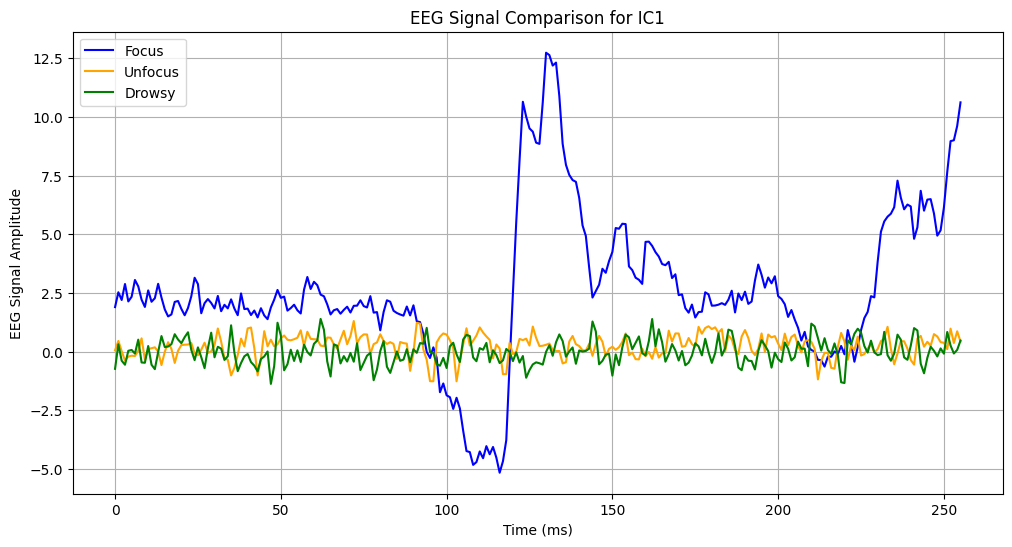

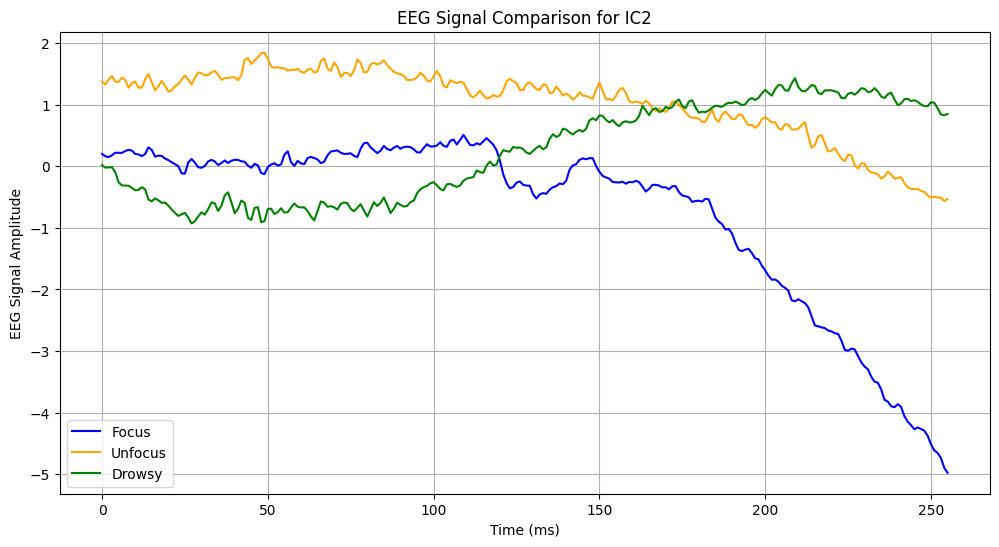

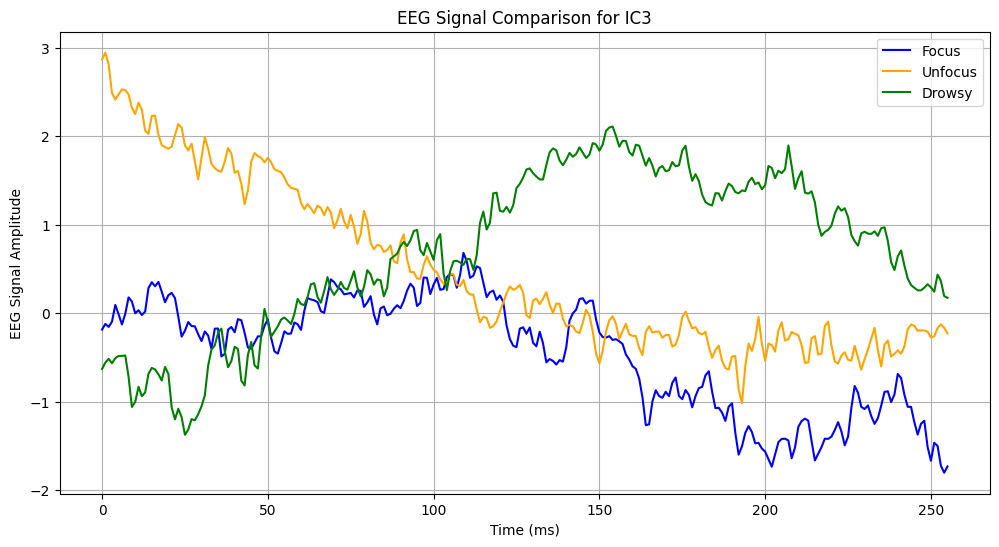

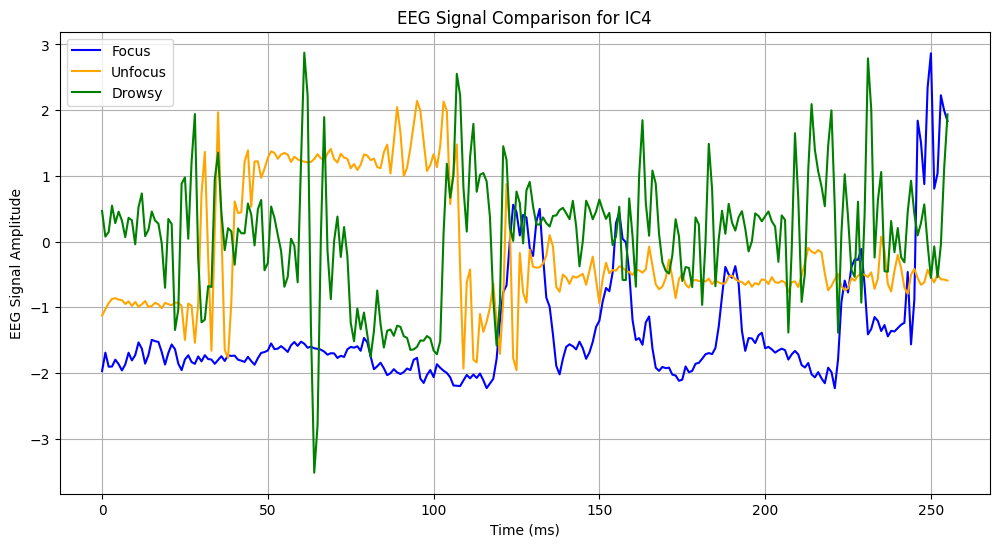

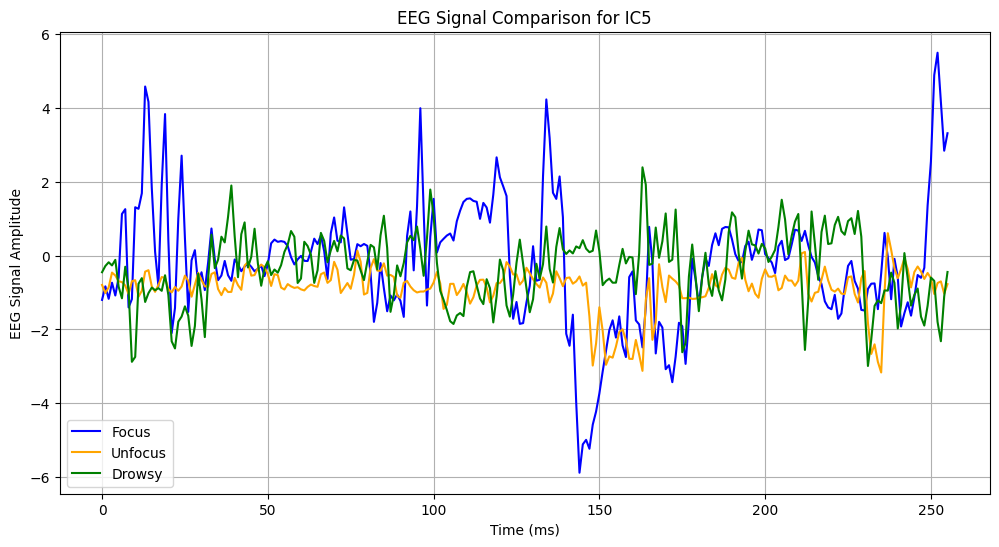

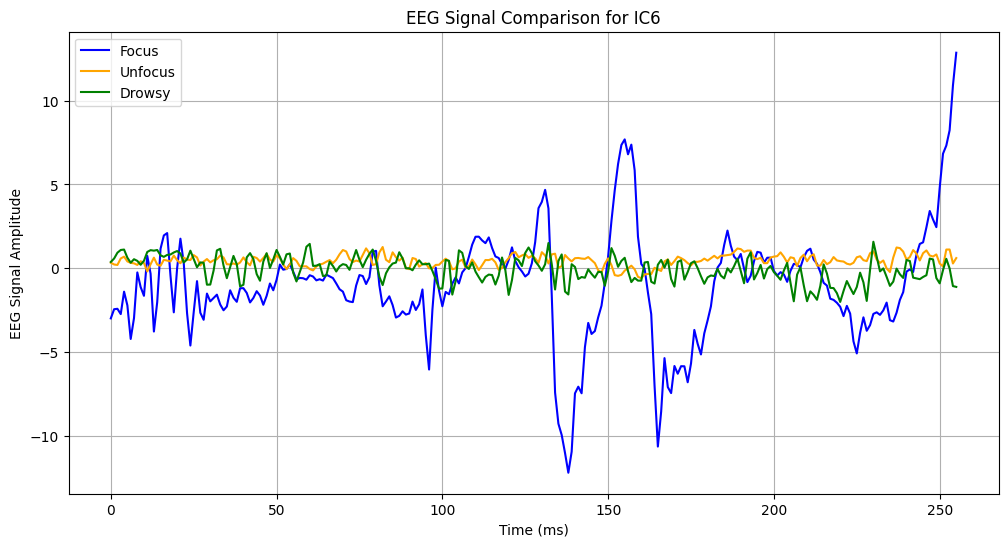

In [25]:
sample_idx = 1
channels = ['IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6']

for idx in range(0, 6):
    plt.figure(figsize=(12, 6))
    
    focused_signal = focus_train[sample_idx, :, idx]
    unfocused_signal = unfocus_train[sample_idx, :, idx]
    drowsy_signal = drowsy_train[sample_idx, :, idx]
    
    time = np.arange(256)  
    
    plt.plot(time, focused_signal, label='Focus', color='blue')
    plt.plot(time, unfocused_signal, label='Unfocus', color='orange')
    plt.plot(time, drowsy_signal, label='Drowsy', color='green')
    
    plt.xlabel('Time (ms)')
    plt.ylabel('EEG Signal Amplitude')
    plt.title(f'EEG Signal Comparison for {channels[idx]}')
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [26]:
focus_test, unfocus_test, drowsy_test = [], [], []
idx_test = [31, 32, 33, 34]

for count in idx_test:
    eeg_data = ica_eeg_data_dict[f'eeg_data_{count}'][0] 
    
    focus, unfocus, drowsy = [], [], []
    focus, unfocus, drowsy = split_eeg_data(eeg_data)

    temp_focus = split_eeg_data_by_time(focus, flag)
    temp_unfocus = split_eeg_data_by_time(unfocus, flag)
    temp_drowsy = split_eeg_data_by_time(drowsy, flag)

    for i in range(len(temp_focus)):
        focus_test.append(temp_focus[i])

    for i in range(len(temp_unfocus)):
        unfocus_test.append(temp_unfocus[i])

    for i in range(len(temp_drowsy)):
        drowsy_test.append(temp_drowsy[i])
    

In [27]:
focus_test = np.stack(focus_test, axis=0)
print("Kích thước focus_test", focus_test.shape)

unfocus_test = np.stack(unfocus_test, axis=0)
print("Kích thước unfocus_test:", unfocus_test.shape)

drowsy_test = np.stack(drowsy_test, axis=0)
print("Kích thước drowsy_test:", drowsy_test.shape)


Kích thước focus_test (1200, 256, 6)
Kích thước unfocus_test: (1200, 256, 6)
Kích thước drowsy_test: (4649, 256, 6)


In [28]:
indices_drowsy = np.arange(0, 1200)  
drowsy_test = drowsy_test[indices_drowsy]

print("Shape of drowsy_test:", drowsy_test.shape)

Shape of drowsy_test: (1200, 256, 6)


In [29]:
focus_labels = np.full(focus_test.shape[0], 2, dtype=int)
unfocus_labels = np.ones(unfocus_test.shape[0], dtype=int)
drowsy_labels = np.zeros(drowsy_test.shape[0], dtype=int)

print(f"focus_labels: {len(focus_labels)}; unfocus_labels: {len(unfocus_labels)}; drowsy_labels: {len(drowsy_labels)}")

focus_labels: 1200; unfocus_labels: 1200; drowsy_labels: 1200


In [30]:
X_test = np.concatenate([focus_test, unfocus_test, drowsy_test], axis=0)
y_test = np.concatenate([focus_labels, unfocus_labels, drowsy_labels], axis=0)

print(f"x_test: {X_test.shape}; y_test: {y_test.shape}")

x_test: (3600, 256, 6); y_test: (3600,)


### IV. Feature Engineering

In [31]:
from scipy.fft import fft
from scipy.signal import welch
from scipy.stats import entropy, kurtosis, skew


In [32]:
def extract_frequency_features(signal, sampling_rate):
    """
    Trích xuất các đặc trưng miền tần số từ tín hiệu EEG.
    
    Parameters:
        signal (numpy.ndarray): Dữ liệu tín hiệu, shape (samples, channels).
        sampling_rate (int): Tần số lấy mẫu của tín hiệu.
    Returns:
        numpy.ndarray: Đặc trưng miền tần số cho từng kênh.
    """

    features = []
    n_samples, n_channels = signal.shape

    for ch in range(n_channels):
        fft_values = np.abs(fft(signal[:, ch]))[:n_samples // 2] 
        freqs = np.fft.fftfreq(n_samples, d=1/sampling_rate)[:n_samples // 2]

        peak_freq = freqs[np.argmax(fft_values)]
        mean_freq = np.sum(freqs * fft_values) / np.sum(fft_values)
        spectral_entropy = entropy(fft_values / np.sum(fft_values))

        features.extend([peak_freq, mean_freq, spectral_entropy])
    
    return np.array(features)


In [33]:
def extract_band_power(signal, sampling_rate):
    """
    Tính năng lượng trong các băng tần EEG.
    
    Parameters:
        signal (numpy.ndarray): Dữ liệu tín hiệu, shape (samples, channels).
        sampling_rate (int): Tần số lấy mẫu của tín hiệu.
    Returns:
        numpy.ndarray: Năng lượng băng tần cho từng kênh.
    """
    
    band_limits = {
        "theta": (4, 8),
        "alpha": (8, 12),
        "beta": (12, 30),
    }
    
    features = []
    n_samples, n_channels = signal.shape
    
    for ch in range(n_channels):
        freqs, psd = welch(signal[:, ch], fs=sampling_rate, nperseg=n_samples)

        band_powers = []
        for band, (low, high) in band_limits.items():
            band_power = np.sum(psd[(freqs >= low) & (freqs < high)])
            band_powers.append(band_power)
        
        total_power = np.sum(band_powers)
        relative_powers = [p / total_power for p in band_powers]
        
        features.extend(relative_powers)
    
    return np.array(features)


In [34]:
def extract_features(signal, sampling_rate):
    """
    Tích hợp cả Frequency Domain Features và Band Power.

    Parameters:
        signal (numpy.ndarray): Dữ liệu tín hiệu, có thể dạng (samples, channels) hoặc (windows, samples, channels).
        sampling_rate (int): Tần số lấy mẫu của tín hiệu.
    Returns:
        numpy.ndarray: Đặc trưng tổng hợp.
    """
    
    if len(signal.shape) == 2:  # Dạng (samples, channels)
        freq_features = extract_frequency_features(signal, sampling_rate)
        band_power_features = extract_band_power(signal, sampling_rate)
        return np.hstack([freq_features, band_power_features])
    elif len(signal.shape) == 3:  # Dạng (windows, samples, channels)
        features = []
        for window in signal:
            freq_features = extract_frequency_features(window, sampling_rate)
            band_power_features = extract_band_power(window, sampling_rate)
            features.append(np.hstack([freq_features, band_power_features]))
        return np.array(features)
    else:
        raise ValueError("Input signal must be 2D or 3D array.")


In [35]:
X_train = extract_features(X_train, sampling_rate=128)
X_test = extract_features(X_test, sampling_rate=128)
print(f"shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")


shape of X_train: (35940, 36)
Shape of X_test: (3600, 36)


## V. Training Models

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### 1. Model Logistic Regression

In [38]:
LogisticRegression_model = LogisticRegression(C = 10, max_iter=1000, penalty='l1', solver = 'saga', random_state=42)
LogisticRegression_model.fit(X_train, y_train)


LogisticRegression(C=10, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')

In [39]:
y_pred = LogisticRegression_model.predict(X_test)


In [40]:
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average='weighted'),
    "Recall": recall_score(y_test, y_pred, average='weighted'),
    "F1 Score": f1_score(y_test, y_pred, average='weighted'),
}

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [42]:
metrics_df = pd.DataFrame(metrics, index=["Test Set"])
classification_rep = classification_report(y_test, y_pred, target_names=["Drowsy - 0", "Unfocus - 1", "Focus - 2"])
print(metrics_df)
print("\nClassification Report - Test Set:\n", classification_rep)


          Accuracy  Precision    Recall  F1 Score
Test Set  0.395833   0.392462  0.395833  0.393761

Classification Report - Test Set:
               precision    recall  f1-score   support

  Drowsy - 0       0.31      0.29      0.30      1200
 Unfocus - 1       0.42      0.41      0.42      1200
   Focus - 2       0.45      0.48      0.47      1200

    accuracy                           0.40      3600
   macro avg       0.39      0.40      0.39      3600
weighted avg       0.39      0.40      0.39      3600



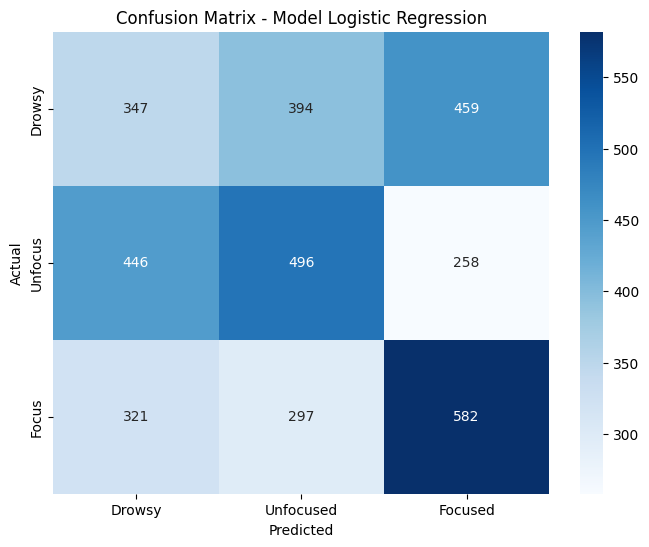

In [43]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Drowsy", "Unfocused", "Focused"], yticklabels=["Drowsy", "Unfocus", "Focus"])
plt.title("Confusion Matrix - Model Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 2. Model SVM Linear

In [44]:
linear_svm = SVC(kernel='linear', random_state=42)
linear_svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [45]:
y_pred = linear_svm.predict(X_test)


In [46]:
conf_matrix = confusion_matrix(y_test, y_pred)


In [47]:
metrics_df = pd.DataFrame(metrics, index=["Test Set"])
classification_rep = classification_report(y_test, y_pred, target_names=["Drowsy - 0", "Unfocus - 1", "Focus - 2"])
print(metrics_df)
print("\nClassification Report - Test Set:\n", classification_rep)

          Accuracy  Precision    Recall  F1 Score
Test Set  0.395833   0.392462  0.395833  0.393761

Classification Report - Test Set:
               precision    recall  f1-score   support

  Drowsy - 0       0.33      0.30      0.31      1200
 Unfocus - 1       0.42      0.42      0.42      1200
   Focus - 2       0.46      0.51      0.48      1200

    accuracy                           0.41      3600
   macro avg       0.40      0.41      0.41      3600
weighted avg       0.40      0.41      0.41      3600



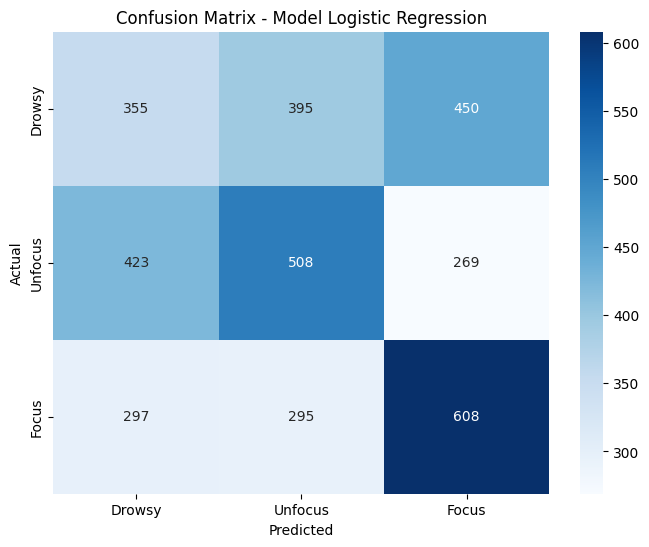

In [48]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Drowsy", "Unfocus", "Focus"], yticklabels=["Drowsy", "Unfocus", "Focus"])
plt.title("Confusion Matrix - Model Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 3. Model Random Forest

In [49]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
y_pred = random_forest.predict(X_test)

In [51]:
conf_matrix = confusion_matrix(y_test, y_pred)


In [52]:
metrics_df = pd.DataFrame(metrics, index=["Test Set"])
classification_rep = classification_report(y_test, y_pred, target_names=["Drowsy - 0", "Unfocus - 1", "Focus - 2"])
print(metrics_df)
print("\nClassification Report - Test Set:\n", classification_rep)


          Accuracy  Precision    Recall  F1 Score
Test Set  0.395833   0.392462  0.395833  0.393761

Classification Report - Test Set:
               precision    recall  f1-score   support

  Drowsy - 0       0.22      0.19      0.20      1200
 Unfocus - 1       0.41      0.38      0.39      1200
   Focus - 2       0.35      0.42      0.38      1200

    accuracy                           0.33      3600
   macro avg       0.33      0.33      0.33      3600
weighted avg       0.33      0.33      0.33      3600



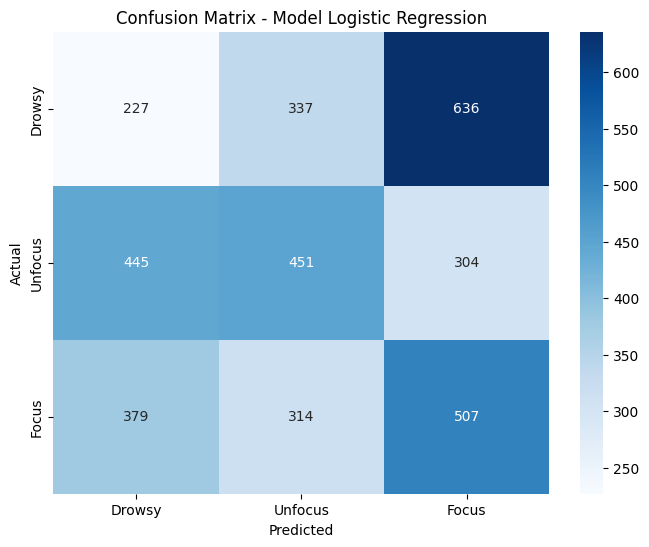

In [53]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Drowsy", "Unfocus", "Focus"], yticklabels=["Drowsy", "Unfocus", "Focus"])
plt.title("Confusion Matrix - Model Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
